In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="3"

Sat Jan 27 22:33:10 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.223.02   Driver Version: 470.223.02   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100 80G...  Off  | 00000000:1B:00.0 Off |                    0 |
| N/A   43C    P0    47W / 300W |     35MiB / 80994MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100 80G...  Off  | 00000000:1C:00.0 Off |                    0 |
| N/A   

### Model Parts

In [3]:
from model.main.enc_prior_latent_quantizer_dec import Model
from model.encoder.net_64_encoder import Encoder
from model.prior.dalle_rand_prior import Prior
from model.latent.dalle_lse_latent import Latent
from model.quantizer.dalle_nearest_quantizer import Quantizer
from model.decoder.net_64_decoder import Decoder

from tensorboardX import SummaryWriter
from util.util import *

### Model Init.

In [4]:
from easydict import EasyDict
hp = EasyDict()
hp.img_size = 64
hp.n_resblocks = 6
hp.z_dim = 2
hp.n_prior_embeddings = 512
hp.init_log_sigma = 0
hp.const_sigma = False
hp.quantize = False
hp.prior_mu = 0.999
hp.z_activation = F.tanh
hp.M = hp.n_prior_embeddings

In [5]:
step = 0
device = 'cuda:0'

model_list = []
optimizer_list = []
for i in range(1):
    model = Model(Encoder(**hp), Prior(**hp), Latent(**hp), Quantizer(**hp), Decoder(**hp))
    model = model.to(device)
    model_list.append(model)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
    optimizer_list.append(optimizer)

for name, module in model.named_modules():
    if len(name.split('.')) <= 2 and len(name) > 0:
        print(name, get_size(module))

print('done')

encoder 0.001674652099609375
encoder.encoder 0.001674652099609375
prior 0.005859375
latent 3.814697265625e-06
quantizer 0.0
decoder 0.0014801025390625
decoder.decoder 0.0014801025390625
done


### Load

In [6]:
save_dir = '/data/scpark/save/lse/train_dalle/train01.27-8_1e-3/'

!mkdir -p $save_dir
!ls -lt $save_dir

writer = SummaryWriter(save_dir)

if False:
    step, model_list, optimizer_list = load_model_list(save_dir, 660000, model_list, optimizer_list)

total 0


### Dataset

In [7]:
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import CelebA

class MyCelebA(CelebA):
    """
    A work-around to address issues with pytorch's celebA dataset class.
    
    Download and Extract
    URL : https://drive.google.com/file/d/1m8-EBPgi5MRubrm6iQjafK2QMHDBMSfJ/view?usp=sharing
    """
    
    def _check_integrity(self) -> bool:
        return True

root = '/data'
train_transforms = transforms.Compose([transforms.RandomHorizontalFlip(),
                                       transforms.CenterCrop(148),
                                       transforms.Resize(hp.img_size),
                                       transforms.ToTensor(),])
train_dataset = MyCelebA(root, split='train', transform=train_transforms, download=False)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
print('done')

done


In [8]:
def preprocess(batch):
    x, t = batch
    data = {}
    data['x'] = x.to(device)
    data['t'] = t.to(device)
    return data

### Train

In [9]:
def plot(x):
    _x = x.permute(0, 2, 3, 1).data.cpu().numpy()
    plt.figure(figsize=[18, 4])
    for i in range(8):
        plt.subplot(1, 8, i+1)
        plt.imshow(_x[i])
        plt.xticks([])
        plt.yticks([])
    plt.show()

In [10]:
def linear(start_value, end_value, current_index, start_index, end_index):
    if current_index > end_index:
        return end_value
    if current_index < start_index:
        return start_value

    grad = (end_value - start_value) / (end_index - start_index)
    y = start_value + grad * (current_index - start_index)

    return y

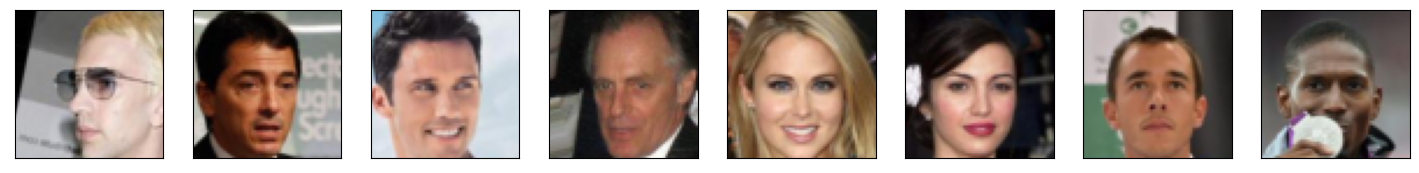

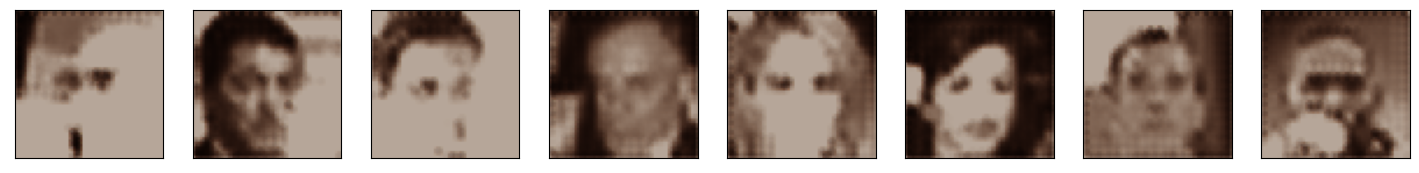

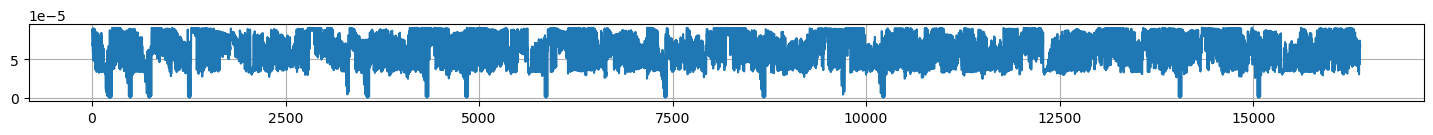

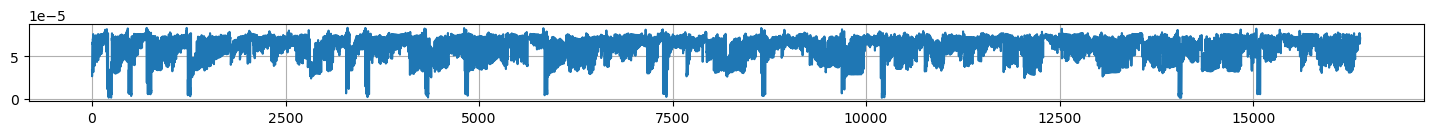

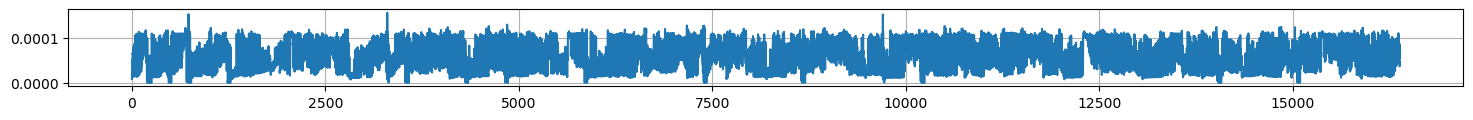

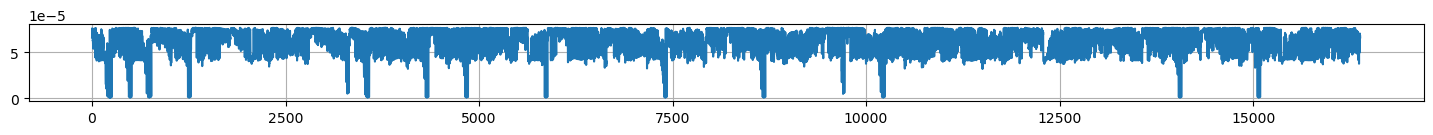

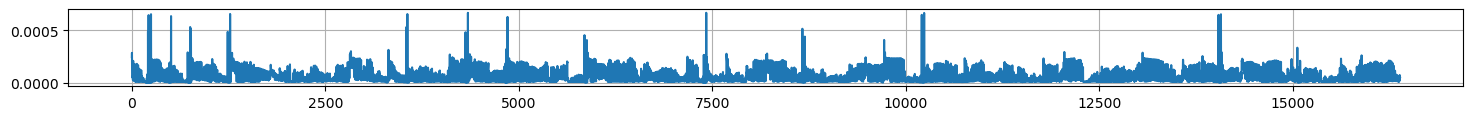

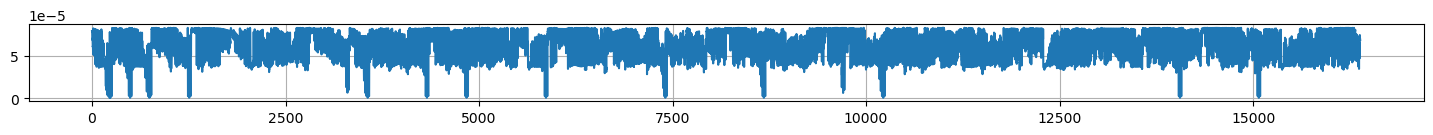

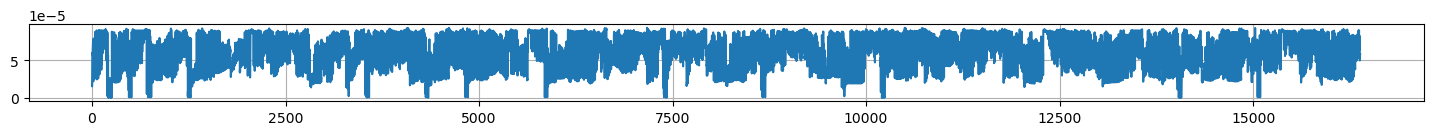

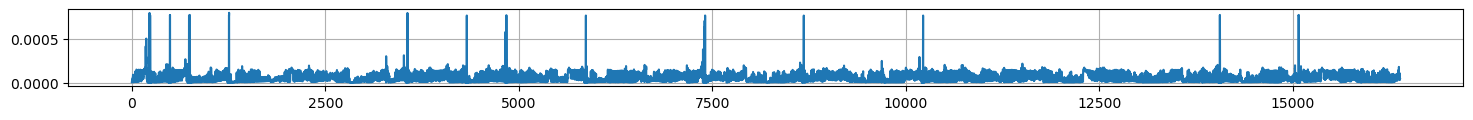

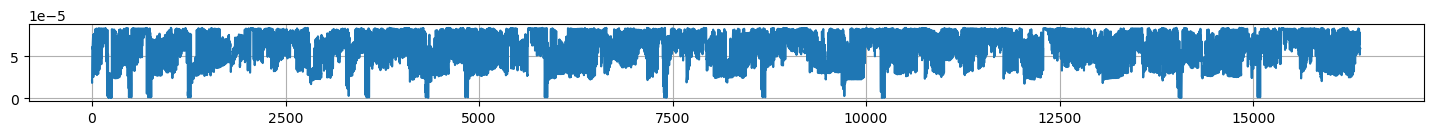

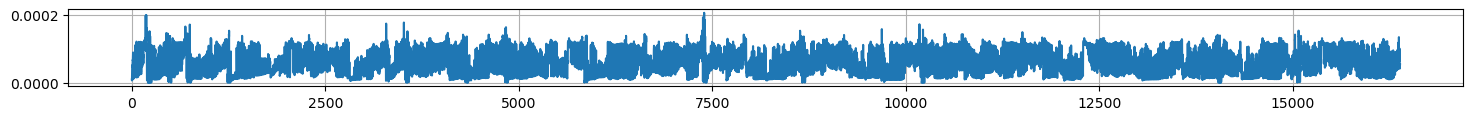

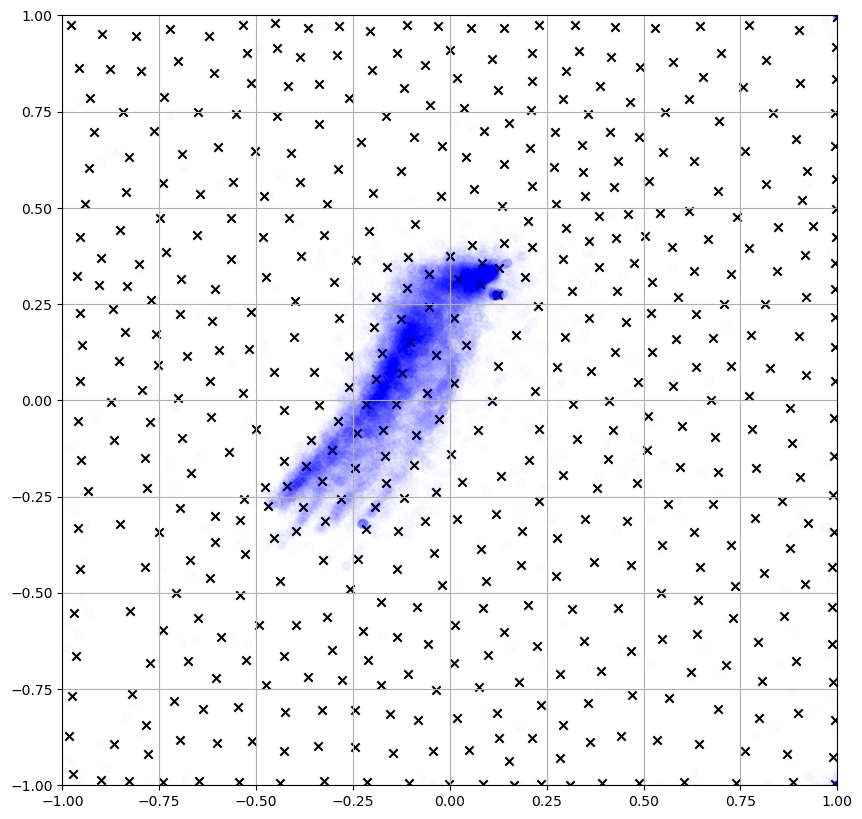

10001
lse_loss -1.059779167175293
commit_loss 0.00043222817475907505
recon_loss 0.014997179619967937
10002
lse_loss -1.039534568786621
commit_loss 0.0004451655549928546
recon_loss 0.014240451157093048
10003
lse_loss -1.0509233474731445
commit_loss 0.00042194989509880543
recon_loss 0.016453944146633148
10004
lse_loss -1.0523719787597656
commit_loss 0.00042693002615123987
recon_loss 0.015437843278050423
10005
lse_loss -1.070444107055664
commit_loss 0.000490365200676024
recon_loss 0.01721876859664917
10006
lse_loss -1.0513181686401367
commit_loss 0.0004205692675895989
recon_loss 0.013212369754910469
10007
lse_loss -1.0610876083374023
commit_loss 0.00044774863636121154
recon_loss 0.014875488355755806
10008
lse_loss -1.0721654891967773
commit_loss 0.0005003532278351486
recon_loss 0.015567969530820847
10009
lse_loss -1.061701774597168
commit_loss 0.00044268189230933785
recon_loss 0.01358856912702322
10010
lse_loss -1.0622596740722656
commit_loss 0.0004429281398188323
recon_loss 0.01614861562

10085
lse_loss -1.0620794296264648
commit_loss 0.00044099564547650516
recon_loss 0.014203719794750214
10086
lse_loss -1.0617151260375977
commit_loss 0.0004394464776851237
recon_loss 0.015140391886234283
10087
lse_loss -1.0646686553955078
commit_loss 0.00044258963316679
recon_loss 0.014403261244297028
10088
lse_loss -1.063185691833496
commit_loss 0.00044180883560329676
recon_loss 0.014965452253818512
10089
lse_loss -1.0548734664916992
commit_loss 0.0004248404875397682
recon_loss 0.016681881621479988
10090
lse_loss -1.0456609725952148
commit_loss 0.00043359206756576896
recon_loss 0.015278171747922897
10091
lse_loss -1.0610761642456055
commit_loss 0.00043649820145219564
recon_loss 0.01640920899808407
10092
lse_loss -1.055253028869629
commit_loss 0.00042458242387510836
recon_loss 0.015454992651939392
10093
lse_loss -1.0560035705566406
commit_loss 0.0004241179849486798
recon_loss 0.01424148865044117
10094
lse_loss -1.056260108947754
commit_loss 0.0004203607968520373
recon_loss 0.01607441157

10169
lse_loss -1.0667104721069336
commit_loss 0.00045935058733448386
recon_loss 0.016357777640223503
10170
lse_loss -1.0734615325927734
commit_loss 0.0005031361943110824
recon_loss 0.01728520728647709
10171
lse_loss -1.0380334854125977
commit_loss 0.00044545315904542804
recon_loss 0.015518027357757092
10172
lse_loss -1.0584230422973633
commit_loss 0.00042150451918132603
recon_loss 0.015310756862163544
10173
lse_loss -1.052687644958496
commit_loss 0.00041729683289304376
recon_loss 0.015617880038917065
10174
lse_loss -1.0652532577514648
commit_loss 0.0004362407489679754
recon_loss 0.016794605180621147
10175
lse_loss -1.0635337829589844
commit_loss 0.00044392154086381197
recon_loss 0.015019897371530533
10176
lse_loss -1.0560522079467773
commit_loss 0.00041657258407212794
recon_loss 0.016749180853366852
10177
lse_loss -1.0633258819580078
commit_loss 0.0004474003508221358
recon_loss 0.013628455810248852
10178
lse_loss -1.0571775436401367
commit_loss 0.000415017653722316
recon_loss 0.014823

10253
lse_loss -1.0625667572021484
commit_loss 0.00042907861643470824
recon_loss 0.013025469146668911
10254
lse_loss -1.0602912902832031
commit_loss 0.0004132653120905161
recon_loss 0.013440907001495361
10255
lse_loss -1.0603141784667969
commit_loss 0.0004242993309162557
recon_loss 0.01557055301964283
10256
lse_loss -1.0523786544799805
commit_loss 0.00041432748548686504
recon_loss 0.01514153741300106
10257
lse_loss -1.0569543838500977
commit_loss 0.0004328619979787618
recon_loss 0.014748901128768921
10258
lse_loss -1.0607728958129883
commit_loss 0.0004334684053901583
recon_loss 0.01716350018978119
10259
lse_loss -1.0588264465332031
commit_loss 0.0004275152459740639
recon_loss 0.015047548338770866
10260
lse_loss -1.0574274063110352
commit_loss 0.0004227837489452213
recon_loss 0.013654647395014763
10261
lse_loss -1.049881935119629
commit_loss 0.00042392435716465116
recon_loss 0.016882790252566338
10262
lse_loss -1.064204216003418
commit_loss 0.0004248724435456097
recon_loss 0.01607852987

10336
lse_loss -1.0585927963256836
commit_loss 0.00041239761048927903
recon_loss 0.013603368774056435
10337
lse_loss -1.0478191375732422
commit_loss 0.00041591987246647477
recon_loss 0.015576137229800224
10338
lse_loss -1.0525636672973633
commit_loss 0.0004138298681937158
recon_loss 0.015565763227641582
10339
lse_loss -1.0583620071411133
commit_loss 0.0004221039707772434
recon_loss 0.014635497704148293
10340
lse_loss -1.0601615905761719
commit_loss 0.00041997694643214345
recon_loss 0.013871475122869015
10341
lse_loss -1.0645198822021484
commit_loss 0.00044921180233359337
recon_loss 0.01394117996096611
10342
lse_loss -1.0607194900512695
commit_loss 0.0004273508384358138
recon_loss 0.017110684886574745
10343
lse_loss -1.061483383178711
commit_loss 0.0004259650013409555
recon_loss 0.015219396911561489
10344
lse_loss -1.0691251754760742
commit_loss 0.00045655621215701103
recon_loss 0.016011442989110947
10345
lse_loss -1.0670175552368164
commit_loss 0.0004602172411978245
recon_loss 0.017365

10420
lse_loss -1.0654115676879883
commit_loss 0.00043301586993038654
recon_loss 0.013063239865005016
10421
lse_loss -1.062983512878418
commit_loss 0.00043351727072149515
recon_loss 0.01480027660727501
10422
lse_loss -1.0727300643920898
commit_loss 0.00047947876737453043
recon_loss 0.01562715321779251
10423
lse_loss -1.0689458847045898
commit_loss 0.00045269913971424103
recon_loss 0.015418860130012035
10424
lse_loss -1.066049575805664
commit_loss 0.00043786782771348953
recon_loss 0.014758876524865627
10425
lse_loss -1.069523811340332
commit_loss 0.0004506593686528504
recon_loss 0.01498459279537201
10426
lse_loss -1.061899185180664
commit_loss 0.00041458371561020613
recon_loss 0.014929570257663727
10427
lse_loss -1.069976806640625
commit_loss 0.00045231980038806796
recon_loss 0.014017480425536633
10428
lse_loss -1.0561399459838867
commit_loss 0.00041242840234190226
recon_loss 0.013693362474441528


In [ ]:
from IPython import display

while True:
    for batch in train_loader:
        print(step)
        
        loss_dict = {}
        for model, optimizer in zip(model_list, optimizer_list):
            data = preprocess(batch)

            # Forward
            model.train()
            model.zero_grad()
            data = model(data, latent_temp=1)

            # Backward
            loss = 0
            for key in data.keys():
                if 'lse_loss' in key:
                    loss = loss + data[key] * 1e-3
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                elif 'commit_loss' in key:
                    loss = loss + data[key] * 0
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]        
                elif 'loss' in key:
                    loss = loss + data[key]
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                    
            loss.backward()
            optimizer.step()
            
        for key in loss_dict:
            writer.add_scalar(key, np.mean(loss_dict[key]), step)
            print(key, np.mean(loss_dict[key]))
        
        if step % 1000 == 0:
            
            log_sigma = model.latent.log_sigma.item()
            writer.add_scalar('log_sigma', log_sigma, step)
            
            usage = ((data['belong'].sum(dim=0) > 0).sum() / hp.M).item()
            writer.add_scalar('usage', usage, step)            

            import matplotlib.pyplot as plt
            display.clear_output()
            
            x = data['x']
            y = data['y']
            
            plot(x)
            plot(y)
                        
            grad = torch.softmax(data['matrix'], dim=0)
            grad = grad.data.cpu().numpy()

            import matplotlib.pyplot as plt

            for i in np.random.randint(0, grad.shape[1], size=[10]):
                plt.figure(figsize=[18, 1])
                plt.plot(grad[:, i])
                plt.grid()
                plt.show()
            
            e = model.prior.prior.data.cpu().numpy()
            z = data['z'].permute(0, 2, 3, 1).reshape(-1, hp.z_dim).data.cpu().numpy()
            plt.figure(figsize=[10, 10])
            plt.scatter(e[:, 0], e[:, 1], marker='x', alpha=1.0, color='black')
            plt.scatter(z[:, 0], z[:, 1], marker='o', alpha=0.01, color='blue')
            plt.xlim([-1, 1])
            plt.ylim([-1, 1])
            plt.grid()
            plt.show() 
            
        if step % 10000 == 0:
            save_model_list(save_dir, step, model_list, optimizer_list)
                
        step += 1
        

In [ ]:
save_model_list(save_dir, step, model_list, optimizer_list)
print('done')